## Goal is to look across days and get a sense of skill on days that have high vs low soil moisture over CONUS

In [1]:
import xarray as xr
xr.set_options(keep_attrs=True)
import glob
import cftime
import numpy as np
# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.distributed import Client
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [2]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="03:00:00",
    account="P93300041",
    memory="4GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

cluster.scale(8)
client.wait_for_workers(8)


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37031 instead
  warnings.warn(


In [3]:
client

<Client: 'tcp://128.117.208.97:45747' processes=5 threads=5, memory=18.65 GiB>

In [4]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')


In [5]:
model = "cesm2cam6v2"

In [6]:
%%time 
raw  = xr.open_zarr("/glade/derecho/scratch/mdfowler/temp/S2S_zarr/cesm2cam6v2.raw.daily.SOILWATER10CM.geospatial.zarr",consolidated=True)
clim = xr.open_zarr("/glade/derecho/scratch/mdfowler/temp/S2S_zarr/cesm2cam6v2.climatology.daily.SOILWATER10CM.geospatial.zarr",consolidated=True) 
anom = xr.open_zarr("/glade/derecho/scratch/mdfowler/temp/S2S_zarr/cesm2cam6v2.anom.daily.SOILWATER10CM.geospatial.zarr",consolidated=True)



CPU times: user 1.37 s, sys: 296 ms, total: 1.66 s
Wall time: 6.28 s


In [7]:
# Use ensemble mean and select just the initialization date 
ensMean_anom = anom.mean(dim='member').isel(lead=0)

In [8]:
# Select just conus
conus  = ensMean_anom.sel(lat=slice(24,52), lon=slice(230,293))

In [9]:
conus

<xarray.Dataset> Size: 7MB
Dimensions:         (init: 1168, lat: 30, lon: 51)
Coordinates:
    dayofyear       (init) int64 9kB dask.array<chunksize=(366,), meta=np.ndarray>
  * init            (init) datetime64[ns] 9kB 1999-01-04 ... 2023-10-30
  * lat             (lat) float32 120B 24.03 24.97 25.92 ... 49.48 50.42 51.36
    lead            int64 8B 0
  * lon             (lon) float32 204B 230.0 231.2 232.5 ... 290.0 291.2 292.5
Data variables:
    SOILWATER_10CM  (init, lat, lon) float32 7MB dask.array<chunksize=(1, 30, 51), meta=np.ndarray>

## New approach: PCA + K-means of those 
"First reduce dimensionality with PCA to capture main spatial patterns, then cluster in PC space. This often works very well for spatial data." - claude.ai

In [13]:
data =  conus.SOILWATER_10CM.values

n_lat = len(conus.lat.values)
n_lon = len(conus.lon.values)
n_times = len(conus.init.values)
time_index = conus.init.values

n_locations = n_lat * n_lon
data_reshaped = data.reshape(n_times, n_locations)
print(f"Reshaped data: {data_reshaped.shape} (days × spatial_locations)")


Reshaped data: (1168, 1530) (days × spatial_locations)


In [15]:
# Step 1: Handle missing values (ocean points, etc.)
# STRATEGY 1: Identify and remove consistently NaN locations (ocean points)
# This is the most common approach for land-only variables like soil moisture

# Find locations that are ALWAYS NaN (ocean points)
always_nan_mask = np.isnan(data_reshaped).all(axis=0)  # locations that are always NaN
print(f"Always-NaN locations (ocean points): {always_nan_mask.sum()}")
# Find locations that are SOMETIMES NaN (problematic land points)
sometimes_nan_mask = np.isnan(data_reshaped).any(axis=0) & ~always_nan_mask
print(f"Sometimes-NaN locations: {sometimes_nan_mask.sum()}")

# Keep only locations that are never NaN (reliable land points)
valid_locations_mask = ~np.isnan(data_reshaped).any(axis=0)
print(f"Valid land locations: {valid_locations_mask.sum()}")

# Filter data to only include valid land locations
data_land_only = data_reshaped[:, valid_locations_mask]
print(f"Land-only data shape: {data_land_only.shape}")

# Now check if any days have remaining NaN values
remaining_nan_days = np.isnan(data_land_only).any(axis=1)
print(f"Days with remaining NaN values: {remaining_nan_days.sum()}")

# Three options for remaining NaN handling:

# OPTION A: Remove days with any remaining NaN (most conservative)
if remaining_nan_days.sum() > 0:
    print("Option A: Removing days with any remaining NaN values")
    data_clean_A = data_land_only[~remaining_nan_days]
    valid_days_A = np.arange(n_times)[~remaining_nan_days]
    print(f"Option A result: {data_clean_A.shape[0]} days retained")
else:
    data_clean_A = data_land_only
    valid_days_A = np.arange(n_times)

data_clean = data_clean_A
valid_days = valid_days_A
valid_dates = time_index[valid_days]
print(f"Final clean data shape: {data_clean.shape}")

# Store information about which locations were kept for later mapping
valid_locations_indices = np.where(valid_locations_mask)[0]
print(f"Kept {len(valid_locations_indices)} out of {n_locations} total locations")


Always-NaN locations (ocean points): 461
Sometimes-NaN locations: 0
Valid land locations: 1069
Land-only data shape: (1168, 1069)
Days with remaining NaN values: 0
Final clean data shape: (1168, 1069)
Kept 1069 out of 1530 total locations


In [23]:
def find_optimal_clusters(data, max_clusters=15):
    """
    Use elbow method and silhouette score to find optimal number of clusters
    """
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_clusters + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(K_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    ax1.grid(True)
    
    ax2.plot(K_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Return optimal k based on silhouette score
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
    
    return optimal_k, silhouette_scores

def perform_pca_kmeans_clustering(data_matrix, n_components=10, n_clusters=None):
    """
    Perform PCA + K-means clustering on soil moisture anomaly data
    """
    print(f"Original data shape: {data_matrix.shape}")
    print(f"Number of time steps: {data_matrix.shape[0]}")
    print(f"Number of spatial points: {data_matrix.shape[1]}")
    
    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_matrix)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_scaled)
    
    print(f"\nPCA Results:")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")
    
    # Find optimal number of clusters if not specified
    if n_clusters is None:
        n_clusters, _ = find_optimal_clusters(data_pca)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data_pca)
    
    # Calculate silhouette score
    sil_score = silhouette_score(data_pca, cluster_labels)
    print(f"\nClustering Results:")
    print(f"Number of clusters: {n_clusters}")
    print(f"Silhouette score: {sil_score:.3f}")
    
    return {
        'scaler': scaler,
        'pca': pca,
        'kmeans': kmeans,
        'cluster_labels': cluster_labels,
        'data_pca': data_pca,
        'silhouette_score': sil_score
    }

def plot_cluster_analysis(results):
    """
    Create visualizations of clustering results
    """
    cluster_labels = results['cluster_labels']
    data_pca = results['data_pca']
    time_coords = data['init']
    
    # Plot 1: PCA components
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # PC1 vs PC2 colored by cluster
    scatter = axes[0,0].scatter(data_pca[:, 0], data_pca[:, 1], 
                              c=cluster_labels, cmap='tab10', alpha=0.7)
    axes[0,0].set_xlabel('PC1')
    axes[0,0].set_ylabel('PC2')
    axes[0,0].set_title('Clusters in PC Space (PC1 vs PC2)')
    plt.colorbar(scatter, ax=axes[0,0])
    
    # Time series of cluster assignments
    axes[0,1].scatter(range(len(time_coords)), cluster_labels, 
                     c=cluster_labels, cmap='tab10', alpha=0.7)
    axes[0,1].set_xlabel('Time Index')
    axes[0,1].set_ylabel('Cluster')
    axes[0,1].set_title('Cluster Assignment Over Time')
    
    # Cluster frequency
    unique, counts = np.unique(cluster_labels, return_counts=True)
    axes[1,0].bar(unique, counts)
    axes[1,0].set_xlabel('Cluster')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Cluster Frequency')
    
    # PCA explained variance
    pca = results['pca']
    axes[1,1].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
                   np.cumsum(pca.explained_variance_ratio_), 'bo-')
    axes[1,1].set_xlabel('Principal Component')
    axes[1,1].set_ylabel('Cumulative Explained Variance')
    axes[1,1].set_title('PCA Explained Variance')
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

def get_cluster_dates(cluster_labels, time_coords, cluster_id):
    """
    Get dates for a specific cluster
    """
    mask = cluster_labels == cluster_id
    cluster_dates = time_coords[mask]
    return cluster_dates


In [24]:
data_matrix=data_clean


Step 2: Performing PCA + K-means clustering...
Original data shape: (1168, 1069)
Number of time steps: 1168
Number of spatial points: 1069

PCA Results:
Explained variance ratio: [0.18230642 0.06831083 0.04899223 0.04553854 0.0328688  0.03124578
 0.02751761 0.02578928 0.021765   0.02099008 0.01697638 0.01599185
 0.01368223 0.01332716 0.01244689]
Cumulative explained variance: [0.18230642 0.25061727 0.29960948 0.34514803 0.37801683 0.40926263
 0.43678024 0.46256953 0.48433453 0.5053246  0.52230096 0.5382928
 0.5519751  0.56530225 0.57774913]


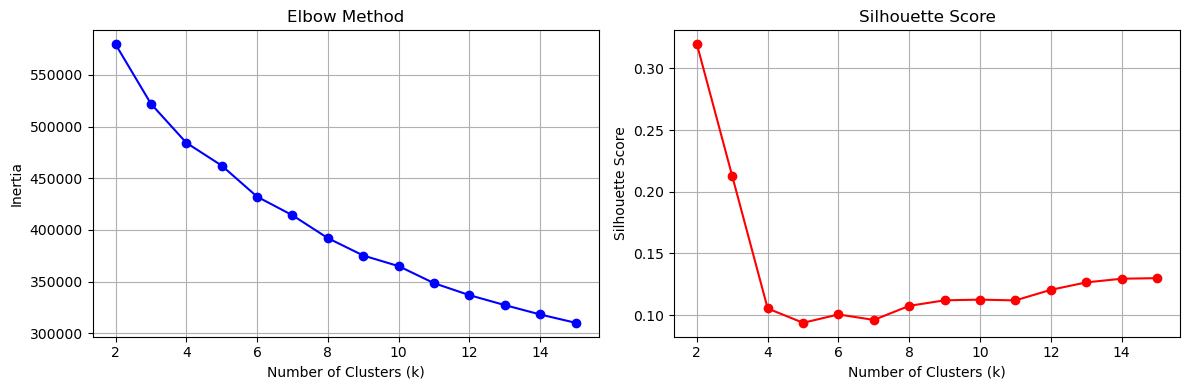

Optimal number of clusters based on silhouette score: 2

Clustering Results:
Number of clusters: 2
Silhouette score: 0.320

Step 3: Plotting results...


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [27]:
print("\nStep 2: Performing PCA + K-means clustering...")
results = perform_pca_kmeans_clustering(
    data_matrix, 
    n_components=15,  # Adjust based on your data
    n_clusters=None   # Will find optimal number
)

print("\nStep 3: Plotting results...")
plot_cluster_analysis(results)

print("\nStep 4: Analyzing specific clusters...")
# Example: Get dates for cluster 0
cluster_0_dates = get_cluster_dates(results['cluster_labels'], 
                                   data['init'], 
                                   cluster_id=0)
print(f"Cluster 0 has {len(cluster_0_dates)} time steps")
print(f"First few dates in cluster 0: {cluster_0_dates[:5]}")


In [26]:
results

{'scaler': StandardScaler(),
 'pca': PCA(n_components=10),
 'kmeans': KMeans(n_clusters=2, n_init=10, random_state=42),
 'cluster_labels': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'data_pca': array([[-10.707825  ,  -4.3508162 ,  -9.874497  , ...,   8.783555  ,
           8.042606  ,   3.0030575 ],
        [-13.386652  ,  -5.1552796 , -10.568116  , ...,   7.772455  ,
           8.671184  ,   1.0926689 ],
        [-14.733414  ,  -9.318435  ,  -8.756939  , ...,  10.291068  ,
           7.3920894 ,   0.39852616],
        ...,
        [-19.443808  , -15.766973  ,   1.3610915 , ...,   6.454019  ,
           3.50825   ,   0.08334843],
        [-24.798918  , -18.475113  ,   3.8987036 , ...,   3.2438498 ,
          -0.7854673 ,  -1.2478135 ],
        [-14.206737  ,  -6.1044765 ,  -4.617962  , ...,   8.6232815 ,
          -4.002715  ,  -2.1428478 ]], dtype=float32),
 'silhouette_score': 0.3546206}

## Compute wet/neutral/dry terciles first! ?

In [9]:
## What if we only want patterns in the warmer months - spring to summer?
# iMonths = np.where((conus['init.month'].values>=4) & (conus['init.month'].values<=10))[0]

# conus_data=np.squeeze(conus.isel(init=iMonths).chunk(dict(init=-1)))

conus_data=np.squeeze(conus.chunk(dict(init=-1)))



In [10]:
# Calculate tercile thresholds for each grid point across all time
# This ignores NaN values automatically
tercile_33 = conus_data.SOILWATER_10CM.quantile(1/3, dim='init')
tercile_67 = conus_data.SOILWATER_10CM.quantile(2/3, dim='init')


In [11]:
print("Tercile thresholds calculated")
print(f"33rd percentile shape: {tercile_33.shape}")

# Create categorical data: 0=dry, 1=neutral, 2=wet
# Using xarray's where function for efficient conditional assignment
soil_categories = xr.where(
    conus_data.SOILWATER_10CM <= tercile_33, 0,  # dry
    xr.where(
        conus_data.SOILWATER_10CM >= tercile_67, 2,  # wet
        1  # neutral (middle tercile)
    )
)

# Add to dataset
conus_data['soil_categories'] = soil_categories

print("Categorical data created:")
print(conus_data.soil_categories)


Tercile thresholds calculated
33rd percentile shape: (30, 51)
Categorical data created:
<xarray.DataArray 'soil_categories' (init: 1168, lat: 30, lon: 51)> Size: 14MB
dask.array<where, shape=(1168, 30, 51), dtype=int64, chunksize=(1168, 30, 51), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  (init) int64 9kB dask.array<chunksize=(1168,), meta=np.ndarray>
  * init       (init) datetime64[ns] 9kB 1999-01-04 1999-01-11 ... 2023-10-30
  * lat        (lat) float32 120B 24.03 24.97 25.92 26.86 ... 49.48 50.42 51.36
    lead       int64 8B 0
  * lon        (lon) float32 204B 230.0 231.2 232.5 233.8 ... 290.0 291.2 292.5


## Try the most naive approach possible for labeling days... 

What if the real areas we care about are the west and the central US?

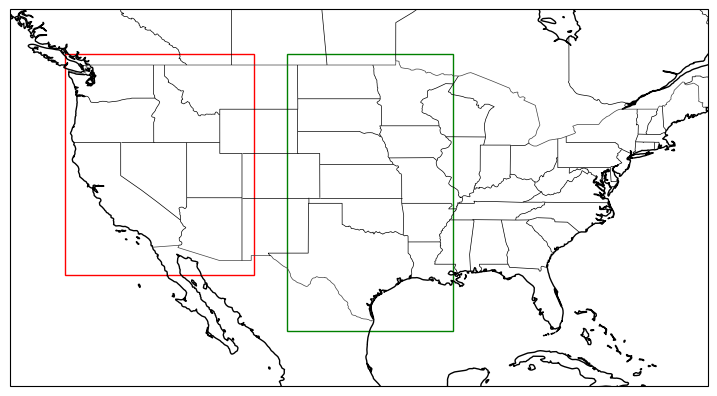

In [12]:
fig, axs = plt.subplots(1,1, figsize=(9,7),subplot_kw={'projection':ccrs.PlateCarree()})
# axs = axs.ravel()

axs.coastlines() 
axs.set_extent([230,293,20,50]) 
axs.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') 
axs.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Western US Soil Moisture
axs.add_patch(patches.Rectangle(xy=[235, 30], width=(252-235), height=(50-30),
                                facecolor='none', edgecolor='r',linestyle='-',
                                linewidth=1, transform=ccrs.PlateCarree()))
# Central US Soil Moisture 
axs.add_patch(patches.Rectangle(xy=[255, 25], width=(270-255), height=(50-25),
                                facecolor='none', edgecolor='g',linestyle='-',
                                linewidth=1, transform=ccrs.PlateCarree()))





In [13]:
conus_data_west    = conus_data.sel(lat=slice(30,50), lon=slice(235,252)).soil_categories.values
conus_data_central = conus_data.sel(lat=slice(25,50), lon=slice(255,270)).soil_categories.values

In [14]:
## Flatten arrays 
n_times, n_lat, n_lon = conus_data_west.shape
west_reshaped   = conus_data_west.reshape(n_times, n_lat * n_lon)

n_times, n_lat, n_lon = conus_data_central.shape
central_reshaped   = conus_data_central.reshape(n_times, n_lat * n_lon)

In [15]:
nSpace_west = len(np.isfinite(west_reshaped[0,:]))
nSpace_central = len(np.isfinite(central_reshaped[0,:]))
nSpace_central

338

In [16]:
## Categorize west and central 
west_category = np.full([n_times], '             ')

threshold = 0.5

for iT in range(n_times):
    iDry     = np.where(west_reshaped[iT,:]==0)[0]
    iNeutral = np.where(west_reshaped[iT,:]==1)[0]
    iWet     = np.where(west_reshaped[iT,:]==2)[0]
    
    if (len(iDry)>=(nSpace_west*threshold)):
        west_category[iT] = 'dry'
    elif (len(iWet)>=(nSpace_west*threshold)):
        west_category[iT] = 'wet'
    elif (len(iNeutral)>=(nSpace_west*threshold)):
        west_category[iT] = 'neutral'
    else: 
        west_category[iT] = 'mixed'


In [17]:
## Categorize west and central 
central_category = np.full([n_times], '             ')

threshold = 0.5

for iT in range(n_times):
    iDry     = np.where(central_reshaped[iT,:]==0)[0]
    iNeutral = np.where(central_reshaped[iT,:]==1)[0]
    iWet     = np.where(central_reshaped[iT,:]==2)[0]
    
    if (len(iDry)>=(nSpace_central*threshold)):
        central_category[iT] = 'dry'
    elif (len(iWet)>=(nSpace_central*threshold)):
        central_category[iT] = 'wet'
    elif (len(iNeutral)>=(nSpace_central*threshold)):
        central_category[iT] = 'neutral'
    else: 
        central_category[iT] = 'mixed'


In [18]:
combinedData = np.full([n_times], '                 ')

for iT in range(n_times):
    combinedData[iT]=west_category[iT]+'+'+central_category[iT]

In [197]:
len(np.unique(combinedData))

15

In [226]:
len(np.where(combinedData=='wet+wet')[0])

28

In [224]:
conus_data['day_label'] = ('init',combinedData)

In [50]:
iJJA = np.where((conus_data['init.month']>=6) & (conus_data['init.month']<=8))[0]
iDJF = np.where((conus_data['init.month']<=2) | (conus_data['init.month']==12))[0]

In [51]:
# file_path = '/glade/derecho/scratch/mdfowler/S2S_processed/SoilMoisture_DailyCategories.nc'
# conus_data.to_netcdf(file_path)

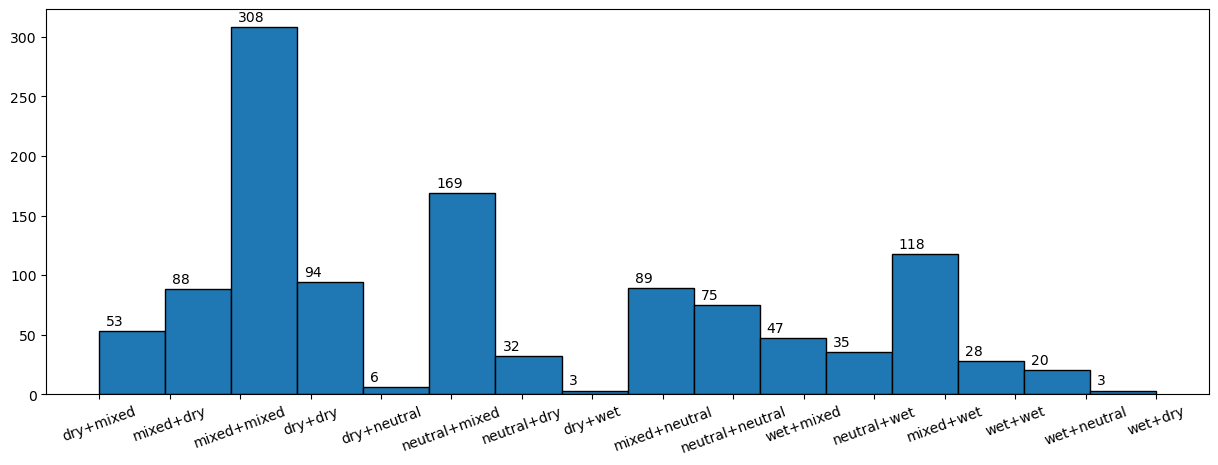

In [52]:
fig,axs=plt.subplots(1,1,figsize=(15,5))
counts,bins,patches = plt.hist(combinedData,bins=len(np.unique(combinedData)), edgecolor='k')
# Add annotations to each bin
for count, bin_ in zip(counts, bins):
    plt.annotate(f'{int(count)}',
                xy=(bin_, count),
                xytext=(bin_ + 0.1, count + 5),
                )


plt.xticks(rotation=20)
plt.show()

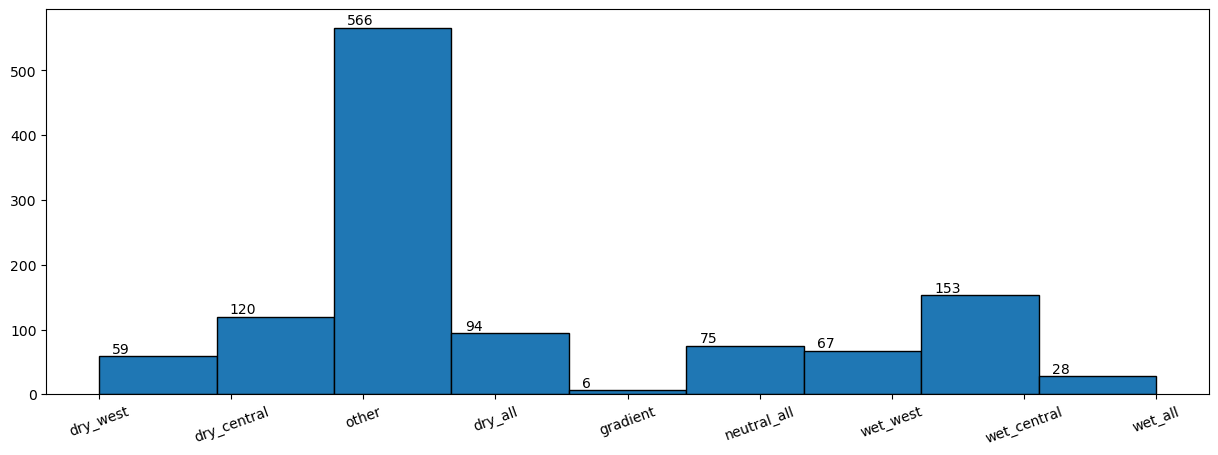

In [53]:
## If I do some manual moving around...
update_labels = combinedData.copy()
update_labels[np.where((combinedData=='dry+mixed') | (combinedData=='dry+neutral'))[0]] = 'dry_west'
update_labels[np.where((combinedData=='mixed+dry') | (combinedData=='neutral+dry'))[0]] = 'dry_central'
update_labels[np.where((combinedData=='wet+mixed') | (combinedData=='wet+neutral'))[0]] = 'wet_west'
update_labels[np.where((combinedData=='mixed+wet') | (combinedData=='neutral+wet'))[0]] = 'wet_central'
update_labels[np.where((combinedData=='dry+wet') | (combinedData=='wet+dry'))[0]] = 'gradient'
update_labels[np.where((combinedData=='mixed+mixed') | (combinedData=='neutral+mixed') | (combinedData=='mixed+neutral'))[0]] = 'other'

update_labels[np.where((combinedData=='wet+wet'))] = 'wet_all'
update_labels[np.where((combinedData=='dry+dry'))] = 'dry_all'
update_labels[np.where((combinedData=='neutral+neutral'))] = 'neutral_all'


fig,axs=plt.subplots(1,1,figsize=(15,5))
counts,bins,patches = plt.hist(update_labels,bins=len(np.unique(update_labels)), edgecolor='k')
# Add annotations to each bin
for count, bin_ in zip(counts, bins):
    plt.annotate(f'{int(count)}',
                xy=(bin_, count),
                xytext=(bin_ + 0.1, count + 5),
                )


plt.xticks(rotation=20)
plt.show()

In [54]:
conus_data['day_label'] = ('init',update_labels)

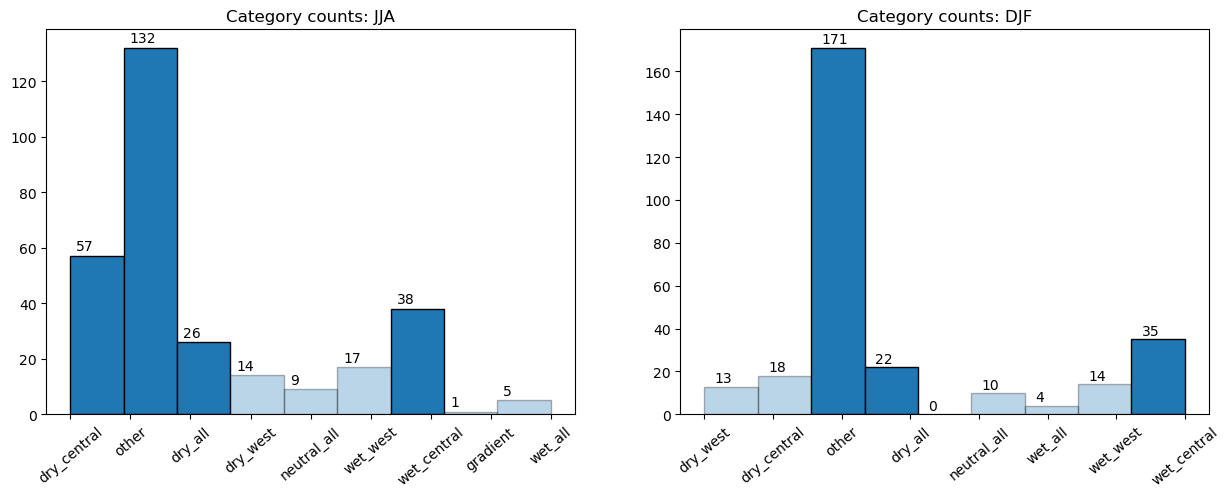

In [55]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
axs = axs.ravel()

counts,bins,patches = axs[0].hist(update_labels[iJJA], bins=len(np.unique(update_labels)), edgecolor='k')
# Add annotations to each bin
for count, bin_ in zip(counts, bins):
    axs[0].annotate(f'{int(count)}',
                xy=(bin_, count),
                xytext=(bin_ + 0.1, count + 2),
                )
axs[0].set_title('Category counts: JJA')
# Modify alpha for bars with fewer than 20 counts
for i, patch in enumerate(patches):
    if counts[i] < 20:  # n[i] contains the count for each bar
        patch.set_alpha(0.3)  # Set lower alpha for bars < 20 counts
    else:
        patch.set_alpha(1.0)  # Keep full opacity for bars >= 20 counts


counts,bins,patches = axs[1].hist(update_labels[iDJF], bins=len(np.unique(update_labels)), edgecolor='k')
# Add annotations to each bin
for count, bin_ in zip(counts, bins):
    axs[1].annotate(f'{int(count)}',
                xy=(bin_, count),
                xytext=(bin_ + 0.15, count + 2),
                )
axs[1].set_title('Category counts: DJF')
# Modify alpha for bars with fewer than 20 counts
for i, patch in enumerate(patches):
    if counts[i] < 20:  # n[i] contains the count for each bar
        patch.set_alpha(0.3)  # Set lower alpha for bars < 20 counts
    else:
        patch.set_alpha(1.0)  # Keep full opacity for bars >= 20 counts


plt.setp( axs[1].xaxis.get_majorticklabels(), rotation=40 )
plt.setp( axs[0].xaxis.get_majorticklabels(), rotation=40 )


plt.show()

In [48]:
print(conus_data.init.values[iDJF])

['2000-11-13T00:00:00.000000000' '2001-12-10T00:00:00.000000000'
 '2001-12-17T00:00:00.000000000' ... '2023-10-16T00:00:00.000000000'
 '2023-10-23T00:00:00.000000000' '2023-10-30T00:00:00.000000000']


In [237]:
file_path = '/glade/derecho/scratch/mdfowler/S2S_processed/SoilMoisture_DailyCategories.nc'
conus_data.to_netcdf(file_path)

(array([156., 603., 311.,  98.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

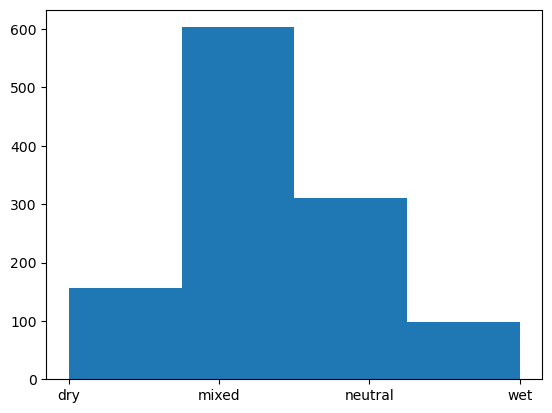

In [217]:
plt.hist(west_category,bins=4)

(array([577., 217., 190., 184.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

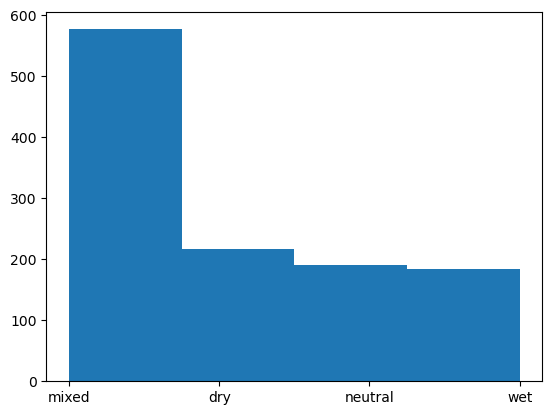

In [218]:
plt.hist(central_category,bins=4)

In [37]:
# Convert to numpy array, handling NaN values
categories_array = conus_data.soil_categories.values  # Shape: (time, lat, lon)

# Reshape for clustering: each row is a day, each column is a location
n_times, n_lat, n_lon = categories_array.shape
categories_reshaped   = categories_array.reshape(n_times, n_lat * n_lon)



In [59]:
print(f"Reshaped for clustering: {categories_reshaped.shape}")

# Handle NaN locations (ocean points)
# Find locations that are always NaN
always_nan_mask = np.isnan(categories_reshaped).all(axis=0)
valid_locations_mask = ~always_nan_mask

print(f"Valid land locations: {valid_locations_mask.sum()}")
print(f"Ocean/invalid locations: {always_nan_mask.sum()}")

# Keep only valid locations
categories_land_only = categories_reshaped[:, valid_locations_mask]

# Check for any remaining NaN values (days with missing data at some land points)
days_with_nan = np.isnan(categories_land_only).any(axis=1)
print(f"Days with some missing land data: {days_with_nan.sum()}")

# For categorical data, we can fill small amounts of missing data with mode (most common category)
if days_with_nan.sum() > 0:
    print("Filling missing land data with spatial mode for each day...")
    for day_idx in np.where(days_with_nan)[0]:
        day_data = categories_land_only[day_idx]
        if np.isnan(day_data).sum() / len(day_data) < 0.05:  # Less than 5% missing
            # Fill with most common category for that day
            valid_data = day_data[~np.isnan(day_data)]
            if len(valid_data) > 0:
                mode_value = np.bincount(valid_data.astype(int)).argmax()
                categories_land_only[day_idx][np.isnan(day_data)] = mode_value

# Final check
final_days_with_nan = np.isnan(categories_land_only).any(axis=1)
if final_days_with_nan.sum() > 0:
    print(f"Removing {final_days_with_nan.sum()} days with excessive missing data")
    categories_clean = categories_land_only[~final_days_with_nan]
    valid_time_indices = np.arange(n_times)[~final_days_with_nan]
    valid_times = conus_data.init[valid_time_indices]
else:
    categories_clean = categories_land_only
    valid_time_indices = np.arange(n_times)
    valid_times = conus_data.init

print(f"Final clean data shape: {categories_clean.shape}")
print(f"Final valid days: {len(valid_times)}")

Reshaped for clustering: (1168, 1530)
Valid land locations: 1530
Ocean/invalid locations: 0
Days with some missing land data: 0
Final clean data shape: (1168, 1530)
Final valid days: 1168


In [61]:
np.shape(categories_clean)

(1168, 1530)

In [49]:
n_space = 1530 # numer of non-Nan grid points, computed below in k-means section

In [62]:
labelDays = np.full([n_times],'                   ')

threshold = 0.5

for iT in range(n_times):
    iDry     = np.where(categories_clean[iT,:]==0)[0]
    iNeutral = np.where(categories_clean[iT,:]==1)[0]
    iWet     = np.where(categories_clean[iT,:]==2)[0]
    if (len(iDry)>=(nSpace*threshold)):
        labelDays[iT] = 'CONUS_dry'
    elif (len(iWet)>=(nSpace*threshold)):
        labelDays[iT] = 'CONUS_wet'
    elif (len(iNeutral)>=(nSpace*threshold)):
        labelDays[iT] = 'CONUS_neutral'
    else: 
        labelDays[iT] = 'CONUS_mixed'

In [63]:
np.unique(labelDays)

array(['CONUS_dry', 'CONUS_mixed', 'CONUS_neutral'], dtype='<U19')

In [65]:
np.where(labelDays=='CONUS_neutral')[0]

array([   5,   14,   18,   20,   22,   23,   24,   25,   26,   27,   28,
         29,   30,   31,   33,   34,   38,   45,   46,   47,   48,   49,
         50,   51,   52,   53,   54,   55,   56,   57,   58,   59,   60,
         61,   62,   63,   64,   65,   66,   67,   68,   69,   70,   71,
         72,   73,   74,   75,   76,   77,   78,   79,   80,   81,   82,
         83,   86,   88,   95,   96,   97,   98,   99,  100,  101,  102,
        103,  104,  105,  106,  107,  108,  109,  110,  111,  112,  113,
        114,  115,  116,  117,  118,  119,  120,  121,  122,  123,  124,
        125,  128,  129,  131,  132,  133,  134,  135,  136,  137,  138,
        139,  140,  141,  142,  143,  144,  145,  146,  148,  149,  150,
        151,  152,  153,  154,  156,  157,  158,  159,  160,  162,  163,
        164,  165,  166,  167,  168,  169,  170,  171,  172,  173,  174,
        175,  176,  177,  178,  179,  180,  181,  182,  183,  184,  185,
        186,  187,  188,  189,  190,  191,  194,  1

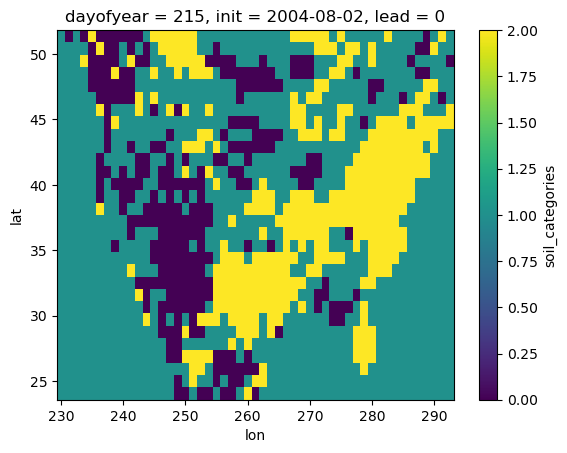

In [66]:
conus_data.soil_categories.isel(init=143).plot()

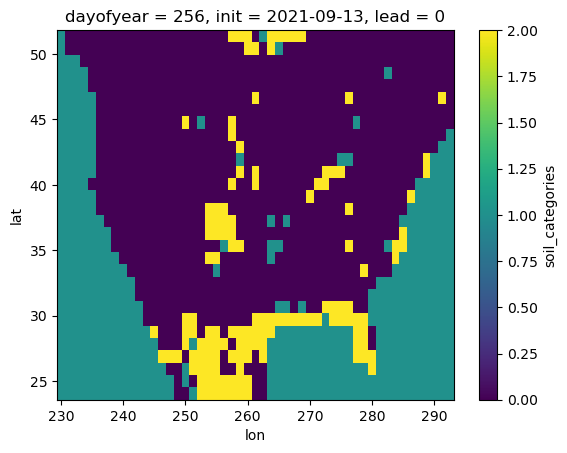

In [58]:
conus_data.soil_categories.isel(init=1056).plot()

## Test K-means on the categorical data

In [48]:
# Prepare data for clustering
chosen_categories = conus_data.soil_categories  # Change this to use different method

# Convert to numpy array, handling NaN values
categories_array = chosen_categories.values  # Shape: (time, lat, lon)

# Reshape for clustering: each row is a day, each column is a location
n_times, n_lat, n_lon = categories_array.shape
categories_reshaped = categories_array.reshape(n_times, n_lat * n_lon)

print(f"Reshaped for clustering: {categories_reshaped.shape}")

# Handle NaN locations (ocean points)
# Find locations that are always NaN
always_nan_mask = np.isnan(categories_reshaped).all(axis=0)
valid_locations_mask = ~always_nan_mask

print(f"Valid land locations: {valid_locations_mask.sum()}")
print(f"Ocean/invalid locations: {always_nan_mask.sum()}")

# Keep only valid locations
categories_land_only = categories_reshaped[:, valid_locations_mask]

# Check for any remaining NaN values (days with missing data at some land points)
days_with_nan = np.isnan(categories_land_only).any(axis=1)
print(f"Days with some missing land data: {days_with_nan.sum()}")

# For categorical data, we can fill small amounts of missing data with mode (most common category)
if days_with_nan.sum() > 0:
    print("Filling missing land data with spatial mode for each day...")
    for day_idx in np.where(days_with_nan)[0]:
        day_data = categories_land_only[day_idx]
        if np.isnan(day_data).sum() / len(day_data) < 0.05:  # Less than 5% missing
            # Fill with most common category for that day
            valid_data = day_data[~np.isnan(day_data)]
            if len(valid_data) > 0:
                mode_value = np.bincount(valid_data.astype(int)).argmax()
                categories_land_only[day_idx][np.isnan(day_data)] = mode_value

# Final check
final_days_with_nan = np.isnan(categories_land_only).any(axis=1)
if final_days_with_nan.sum() > 0:
    print(f"Removing {final_days_with_nan.sum()} days with excessive missing data")
    categories_clean = categories_land_only[~final_days_with_nan]
    valid_time_indices = np.arange(n_times)[~final_days_with_nan]
    valid_times = conus_data.init[valid_time_indices]
else:
    categories_clean = categories_land_only
    valid_time_indices = np.arange(n_times)
    valid_times = conus_data.init

print(f"Final clean data shape: {categories_clean.shape}")
print(f"Final valid days: {len(valid_times)}")


Reshaped for clustering: (1168, 1530)
Valid land locations: 1530
Ocean/invalid locations: 0
Days with some missing land data: 0
Final clean data shape: (1168, 1530)
Final valid days: 1168


In [67]:
# STEP 1: One-Hot Encoding
print("\n=== ONE-HOT ENCODING ===")

# Method 1: Manual one-hot encoding (more control)
def manual_onehot_encode(categories):
    """
    Manually create one-hot encoding for 3 categories (dry, neutral, wet)
    """
    n_days, n_locations = categories.shape
    
    # Create binary arrays for each category
    dry_mask = (categories == 0).astype(float)      # Shape: (n_days, n_locations)
    neutral_mask = (categories == 1).astype(float)  # Shape: (n_days, n_locations)  
    wet_mask = (categories == 2).astype(float)      # Shape: (n_days, n_locations)
    
    # Stack along new dimension: (n_days, n_locations, 3)
    onehot = np.stack([dry_mask, neutral_mask, wet_mask], axis=2)
    
    # Reshape for clustering: each day is a row, each location*category is a column
    # Final shape: (n_days, n_locations * 3)
    onehot_flat = onehot.reshape(n_days, n_locations * 3)
    
    return onehot_flat, onehot

# Apply manual encoding
onehot_data, onehot_3d = manual_onehot_encode(categories_clean)
print(f"One-hot encoded shape: {onehot_data.shape}")
print(f"3D shape for interpretation: {onehot_3d.shape}")

# Verify encoding works correctly
sample_day = 0
sample_location = 10
original_cat = categories_clean[sample_day, sample_location]
encoded_values = onehot_3d[sample_day, sample_location, :]
print(f"Original category at day {sample_day}, location {sample_location}: {original_cat}")
print(f"One-hot encoded: {encoded_values} (should have 1.0 at position {original_cat})")



=== ONE-HOT ENCODING ===
One-hot encoded shape: (1168, 4590)
3D shape for interpretation: (1168, 1530, 3)
Original category at day 0, location 10: 1
One-hot encoded: [0. 1. 0.] (should have 1.0 at position 1)


In [68]:
# Use manual encoding for rest of analysis
clustering_data = onehot_data
print(f"Using data shape: {clustering_data.shape}")

Using data shape: (1168, 4590)



=== K-MEANS CLUSTERING ===
Testing different numbers of clusters...


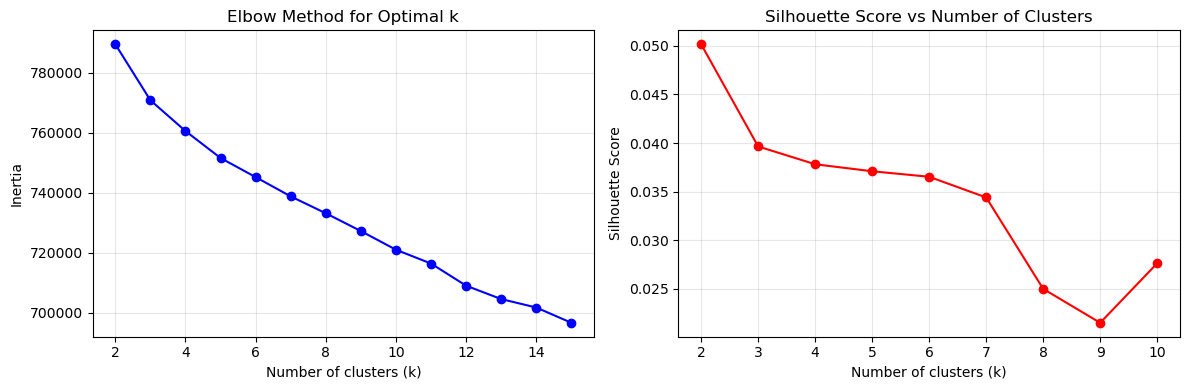

In [69]:
# STEP 2: K-means Clustering
print("\n=== K-MEANS CLUSTERING ===")

# Note: No standardization needed for one-hot encoded data
# (all values are 0 or 1, already on same scale)

# Find optimal number of clusters
inertias = []
silhouette_scores = []
k_range = range(2, 16)

print("Testing different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(clustering_data)
    inertias.append(kmeans.inertia_)
    
    if k <= 10:  # Silhouette score can be slow for large k
        sil_score = silhouette_score(clustering_data, labels)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(0)

# Plot optimization metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)

valid_sil_range = k_range[:len([s for s in silhouette_scores if s > 0])]
valid_sil_scores = [s for s in silhouette_scores if s > 0]
ax2.plot(valid_sil_range, valid_sil_scores, 'ro-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [76]:
# Choose optimal k
optimal_k = valid_sil_range[np.argmax(valid_sil_scores)]
print(f"Optimal k based on silhouette score: {optimal_k}")
optimal_k = 6

Optimal k based on silhouette score: 2


In [77]:


# Final clustering
print(f"Performing final clustering with k={optimal_k}")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(clustering_data)

print(f"Cluster sizes: {np.bincount(cluster_labels)}")


Performing final clustering with k=6
Cluster sizes: [211 225 242 219  82 189]


In [78]:
n_lat = len(conus.lat.values)
n_lon = len(conus.lon.values)
n_times = len(conus.init.values)

n_locations = n_lat * n_lon

In [79]:
# STEP 3: Interpret Results
print("\n=== CLUSTER INTERPRETATION ===")

# Analyze cluster centroids to understand patterns
centroids = kmeans_final.cluster_centers_  # Shape: (n_clusters, n_locations * 3)
centroids_3d = centroids.reshape(optimal_k, n_locations, 3)  # Shape: (n_clusters, n_locations, 3)

# For each cluster, calculate the probability of each category at each location
print("Cluster characteristics:")
for cluster_id in range(optimal_k):
    cluster_mask = cluster_labels == cluster_id
    cluster_size = cluster_mask.sum()
    
    # Get days in this cluster
    cluster_days = np.where(cluster_mask)[0]
    
    # Calculate mean probabilities for this cluster
    dry_prob = centroids_3d[cluster_id, :, 0].mean()
    neutral_prob = centroids_3d[cluster_id, :, 1].mean()
    wet_prob = centroids_3d[cluster_id, :, 2].mean()
    
    print(f"Cluster {cluster_id}: {cluster_size} days")
    print(f"  Average probabilities - Dry: {dry_prob:.3f}, Neutral: {neutral_prob:.3f}, Wet: {wet_prob:.3f}")
    
    # Find locations with strong patterns
    dry_locations = np.where(centroids_3d[cluster_id, :, 0] > 0.6)[0]
    wet_locations = np.where(centroids_3d[cluster_id, :, 2] > 0.6)[0]
    
    print(f"  Predominantly dry locations: {len(dry_locations)}")
    print(f"  Predominantly wet locations: {len(wet_locations)}")



=== CLUSTER INTERPRETATION ===
Cluster characteristics:
Cluster 0: 211 days
  Average probabilities - Dry: 0.422, Neutral: 0.444, Wet: 0.134
  Predominantly dry locations: 572
  Predominantly wet locations: 0
Cluster 1: 225 days
  Average probabilities - Dry: 0.176, Neutral: 0.578, Wet: 0.246
  Predominantly dry locations: 0
  Predominantly wet locations: 16
Cluster 2: 242 days
  Average probabilities - Dry: 0.122, Neutral: 0.534, Wet: 0.344
  Predominantly dry locations: 0
  Predominantly wet locations: 259
Cluster 3: 219 days
  Average probabilities - Dry: 0.229, Neutral: 0.556, Wet: 0.215
  Predominantly dry locations: 50
  Predominantly wet locations: 12
Cluster 4: 82 days
  Average probabilities - Dry: 0.259, Neutral: 0.528, Wet: 0.213
  Predominantly dry locations: 123
  Predominantly wet locations: 60
Cluster 5: 189 days
  Average probabilities - Dry: 0.227, Neutral: 0.556, Wet: 0.217
  Predominantly dry locations: 1
  Predominantly wet locations: 19



=== SPATIAL PATTERN VISUALIZATION ===


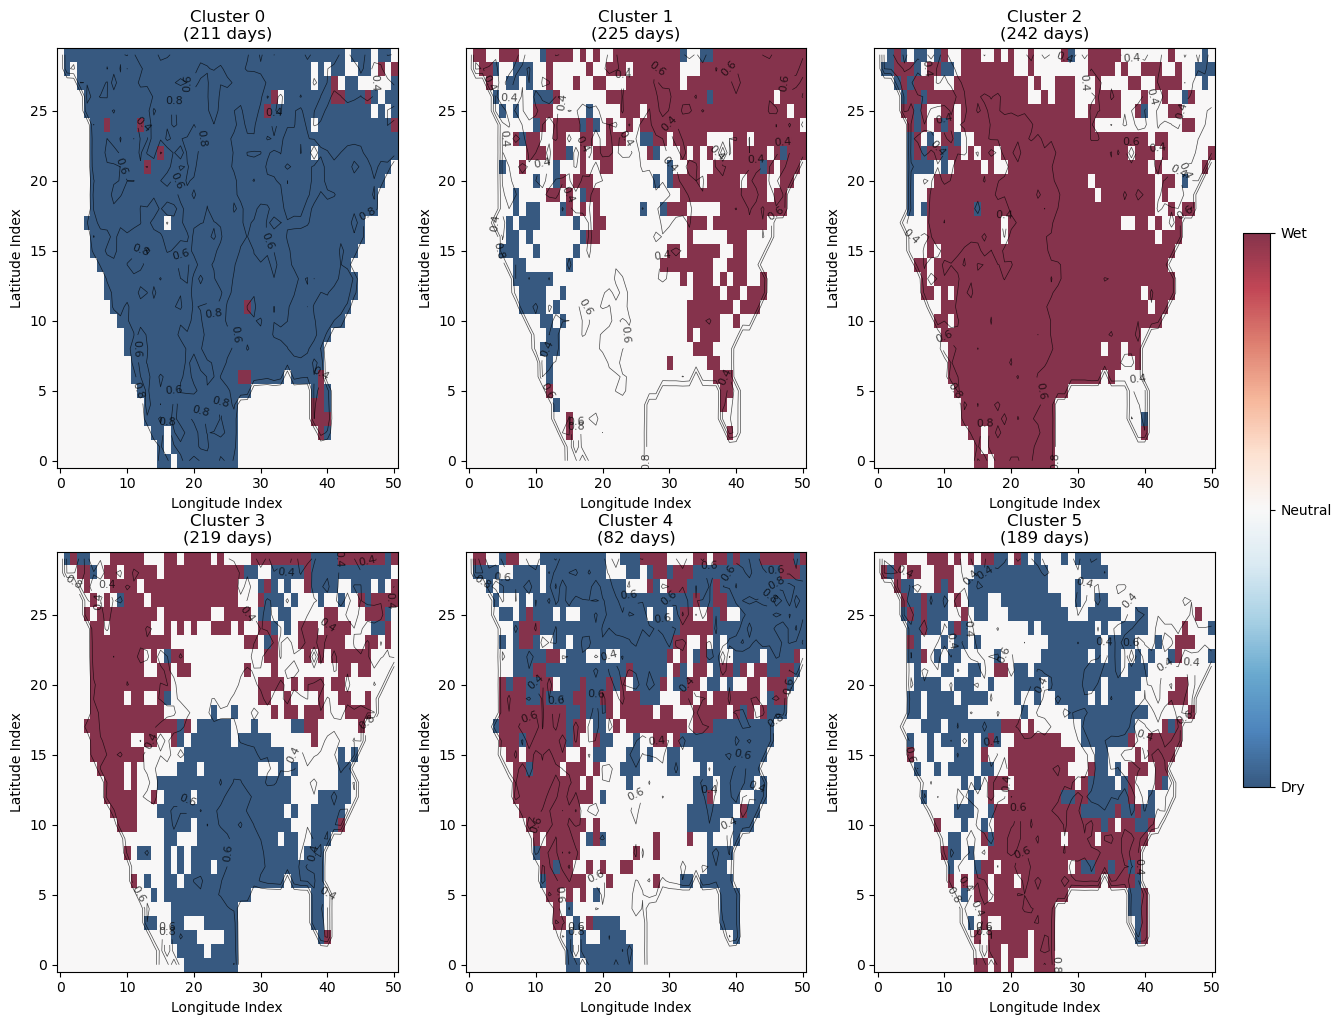

In [80]:
# STEP 4: Visualize Spatial Patterns
print("\n=== SPATIAL PATTERN VISUALIZATION ===")

# For demonstration, let's assume we can map locations back to a spatial grid
# In practice, you'd use your actual lat/lon coordinates
n_lat_demo = len(conus_data.lat.values)
n_lon_demo = len(conus_data.lon.values)
assert n_lat_demo * n_lon_demo == n_locations, "Adjust demo grid size to match n_locations"

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for cluster_id in range(min(optimal_k, 6)):
    if cluster_id < len(axes):
        # Reshape centroid back to spatial grid for each category
        cluster_centroid = centroids_3d[cluster_id]  # Shape: (n_locations, 3)
        
        # Create composite map: dry=red, neutral=white, wet=blue
        # Use the dominant category at each location
        dominant_category = np.argmax(cluster_centroid, axis=1)  # 0=dry, 1=neutral, 2=wet
        confidence = np.max(cluster_centroid, axis=1)  # How confident is the assignment
        
        # Reshape to spatial grid
        spatial_pattern = dominant_category.reshape(n_lat_demo, n_lon_demo)
        confidence_pattern = confidence.reshape(n_lat_demo, n_lon_demo)
        
        # Create colored map
        im = axes[cluster_id].imshow(spatial_pattern, cmap='RdBu_r', vmin=0, vmax=2,
                                   aspect='auto', origin='lower', alpha=0.8)
        
        # Add confidence as contours
        contours = axes[cluster_id].contour(confidence_pattern, levels=[0.4, 0.6, 0.8], 
                                          colors='black', linewidths=0.5, alpha=0.7)
        axes[cluster_id].clabel(contours, inline=True, fontsize=8)
        
        cluster_size = (cluster_labels == cluster_id).sum()
        axes[cluster_id].set_title(f'Cluster {cluster_id}\n({cluster_size} days)')
        axes[cluster_id].set_xlabel('Longitude Index')
        axes[cluster_id].set_ylabel('Latitude Index')

# Add colorbar
if optimal_k > 0:
    cbar = plt.colorbar(im, ax=axes, shrink=0.6, pad=0.02)
    cbar.set_ticks([0, 1, 2])
    cbar.set_ticklabels(['Dry', 'Neutral', 'Wet'])

# Hide unused subplots
for i in range(optimal_k, len(axes)):
    axes[i].set_visible(False)

# plt.tight_layout()
plt.show()


In [81]:
conus_data['cluster_labels'] = ('init', cluster_labels)

In [82]:
conus_data

<xarray.Dataset> Size: 21MB
Dimensions:          (init: 1168, lat: 30, lon: 51)
Coordinates:
    dayofyear        (init) int64 9kB dask.array<chunksize=(1168,), meta=np.ndarray>
  * init             (init) datetime64[ns] 9kB 1999-01-04 ... 2023-10-30
  * lat              (lat) float32 120B 24.03 24.97 25.92 ... 49.48 50.42 51.36
    lead             int64 8B 0
  * lon              (lon) float32 204B 230.0 231.2 232.5 ... 290.0 291.2 292.5
Data variables:
    SOILWATER_10CM   (init, lat, lon) float32 7MB dask.array<chunksize=(1168, 30, 51), meta=np.ndarray>
    soil_categories  (init, lat, lon) int64 14MB dask.array<chunksize=(1168, 30, 51), meta=np.ndarray>
    cluster_labels   (init) int32 5kB 0 0 0 0 4 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

### Sanity check: plot the soil moisture anomalies for those days? 

In [74]:
np.shape(cluster_labels)

(1168,)

In [78]:
np.unique(cluster_labels)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [76]:
conus_data['cluster_labels'] = ('init', cluster_labels)

In [79]:
cluster0_times = np.where(cluster_labels==0)[0]
conus_cluster0 = conus_data.isel(init=cluster0_times)
print(len(conus_cluster0.init.values))

211


In [100]:
conus_cluster0.compute() 

<xarray.Dataset> Size: 4MB
Dimensions:          (init: 211, lat: 30, lon: 51)
Coordinates:
    dayofyear        (init) int64 2kB 4 11 18 25 22 344 ... 275 282 289 296 303
  * init             (init) datetime64[ns] 2kB 1999-01-04 ... 2023-10-30
  * lat              (lat) float32 120B 24.03 24.97 25.92 ... 49.48 50.42 51.36
    lead             int64 8B 0
  * lon              (lon) float32 204B 230.0 231.2 232.5 ... 290.0 291.2 292.5
Data variables:
    SOILWATER_10CM   (init, lat, lon) float32 1MB nan nan nan ... -3.938 -0.7198
    soil_categories  (init, lat, lon) int64 3MB 1 1 1 1 1 1 1 ... 1 1 1 2 1 0 1
    cluster_labels   (init) int32 844B 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

In [98]:
iRand = random.sample(range(0, len(conus_cluster0.init.values)+1), 10)


In [103]:
longrid_anom, latgrid_anom = np.meshgrid(conus_cluster0['lon'], conus_cluster0['lat'] )
normVar_anom  = matplotlib.colors.Normalize(vmin=-10, vmax=10)

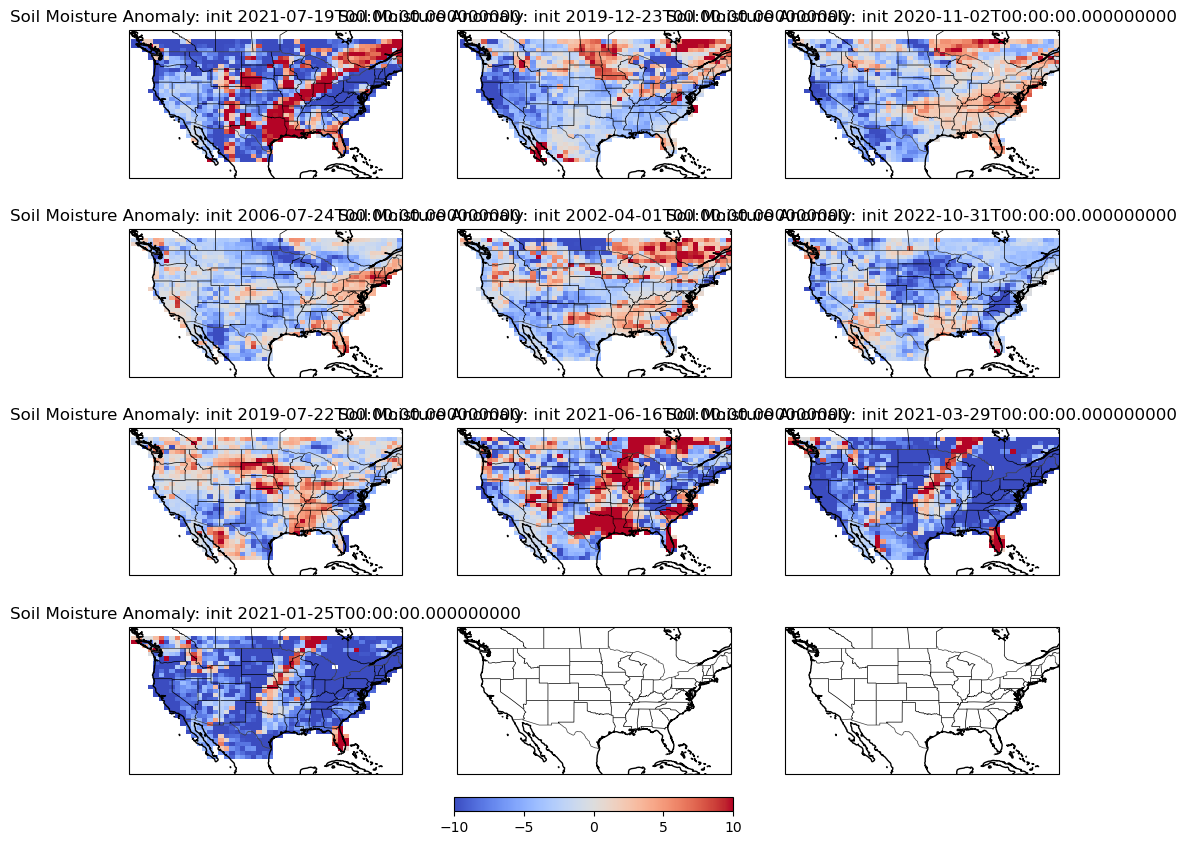

In [109]:
fig, axs = plt.subplots(4,3, figsize=(12,12),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

for iPlt in range(len(iRand)): 
    p=axs[iPlt].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(conus_cluster0.SOILWATER_10CM.isel(init=iRand[iPlt]).values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iPlt].set_title('Soil Moisture Anomaly: init '+ str(conus_cluster0.init.values[iRand[iPlt]]))
 
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='', orientation='horizontal', pad=0.025) 

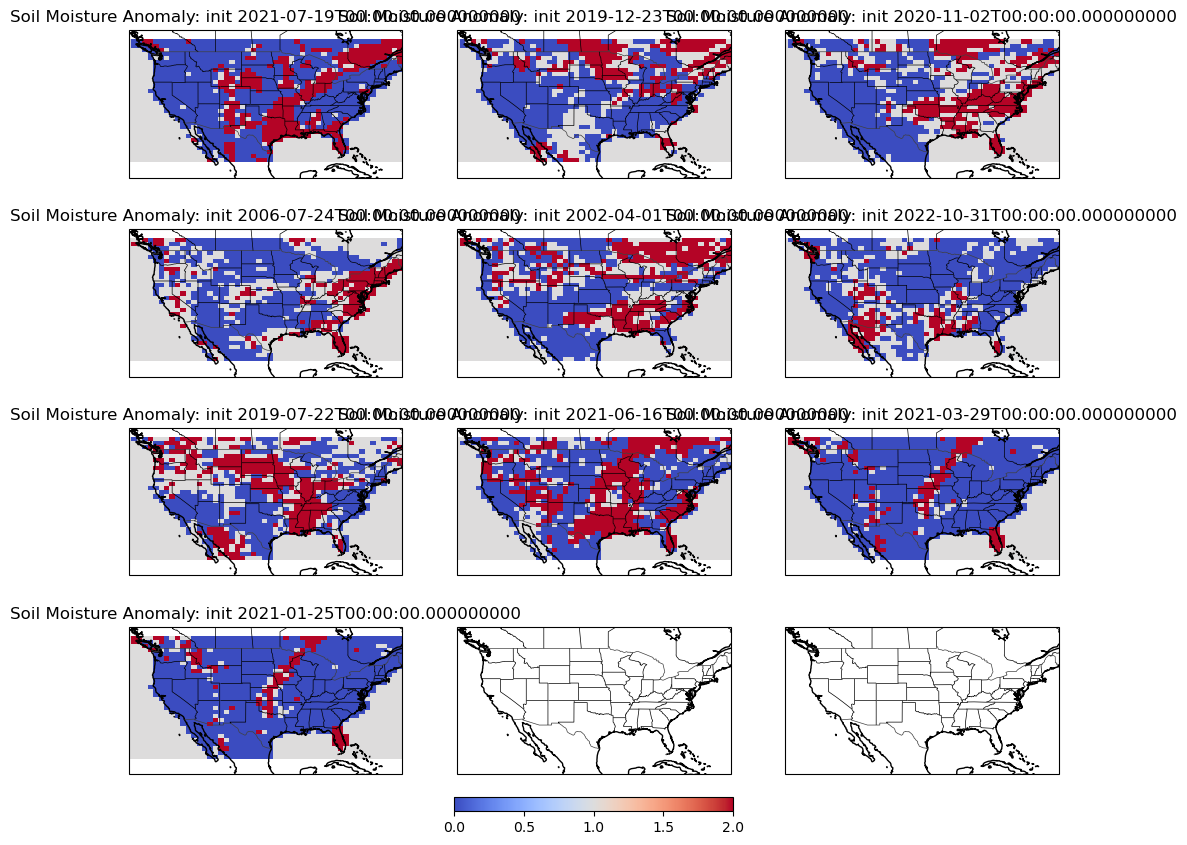

In [110]:
fig, axs = plt.subplots(4,3, figsize=(12,12),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()
normVar_anom  = matplotlib.colors.Normalize(vmin=0, vmax=2)

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

for iPlt in range(len(iRand)): 
    p=axs[iPlt].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(conus_cluster0.soil_categories.isel(init=iRand[iPlt]).values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iPlt].set_title('Soil Moisture Anomaly: init '+ str(conus_cluster0.init.values[iRand[iPlt]]))
 
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='', orientation='horizontal', pad=0.025) 

## Test: K-means clustering

In [42]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [88]:
## What if we just focus in on warm season, JJA?
iMonths = np.where((conus['init.month'].values>=5) & (conus['init.month'].values<=8))[0]
data =  conus.SOILWATER_10CM.isel(init=iMonths).values


In [89]:
n_lat = len(conus.lat.values)
n_lon = len(conus.lon.values)
n_times = len(conus.isel(init=iMonths).init.values)

n_locations = n_lat * n_lon
data_reshaped = data.reshape(n_times, n_locations)
print(f"Reshaped data: {data_reshaped.shape} (days × spatial_locations)")


Reshaped data: (405, 1530) (days × spatial_locations)


In [90]:
time_index = conus.isel(init=iMonths).init.values

In [91]:
# Step 1: Handle missing values
nan_mask = np.isnan(data_reshaped).any(axis=1)
print(f"Days with NaN values: {nan_mask.sum()}")

if nan_mask.sum() > 0:
    data_clean = data_reshaped[~nan_mask]
    valid_days = np.arange(n_times)[~nan_mask]
    valid_dates = time_index[~nan_mask]
else:
    data_clean = data_reshaped
    valid_days = np.arange(n_times)
    valid_dates = time_index

print(f"Clean data shape: {data_clean.shape}")


Days with NaN values: 405
Clean data shape: (0, 1530)


In [92]:
# Step 1: Handle missing values (ocean points, etc.)
# STRATEGY 1: Identify and remove consistently NaN locations (ocean points)
# This is the most common approach for land-only variables like soil moisture

# Find locations that are ALWAYS NaN (ocean points)
always_nan_mask = np.isnan(data_reshaped).all(axis=0)  # locations that are always NaN
print(f"Always-NaN locations (ocean points): {always_nan_mask.sum()}")
# Find locations that are SOMETIMES NaN (problematic land points)
sometimes_nan_mask = np.isnan(data_reshaped).any(axis=0) & ~always_nan_mask
print(f"Sometimes-NaN locations: {sometimes_nan_mask.sum()}")

# Keep only locations that are never NaN (reliable land points)
valid_locations_mask = ~np.isnan(data_reshaped).any(axis=0)
print(f"Valid land locations: {valid_locations_mask.sum()}")

# Filter data to only include valid land locations
data_land_only = data_reshaped[:, valid_locations_mask]
print(f"Land-only data shape: {data_land_only.shape}")

# Now check if any days have remaining NaN values
remaining_nan_days = np.isnan(data_land_only).any(axis=1)
print(f"Days with remaining NaN values: {remaining_nan_days.sum()}")

# Three options for remaining NaN handling:

# OPTION A: Remove days with any remaining NaN (most conservative)
if remaining_nan_days.sum() > 0:
    print("Option A: Removing days with any remaining NaN values")
    data_clean_A = data_land_only[~remaining_nan_days]
    valid_days_A = np.arange(n_times)[~remaining_nan_days]
    print(f"Option A result: {data_clean_A.shape[0]} days retained")
else:
    data_clean_A = data_land_only
    valid_days_A = np.arange(n_times)

Always-NaN locations (ocean points): 461
Sometimes-NaN locations: 0
Valid land locations: 1069
Land-only data shape: (405, 1069)
Days with remaining NaN values: 0


In [93]:
data_clean = data_clean_A
valid_days = valid_days_A
valid_dates = time_index[valid_days]
print(f"Final clean data shape: {data_clean.shape}")

# Store information about which locations were kept for later mapping
valid_locations_indices = np.where(valid_locations_mask)[0]
print(f"Kept {len(valid_locations_indices)} out of {n_locations} total locations")


Final clean data shape: (405, 1069)
Kept 1069 out of 1530 total locations


In [94]:
# Step 2: Standardize the data
# This standardizes across spatial locations for each day
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clean)
print(f"Data standardized: mean = {data_scaled.mean():.3f}, std = {data_scaled.std():.3f}")


Data standardized: mean = 0.000, std = 1.000


Testing different numbers of clusters...


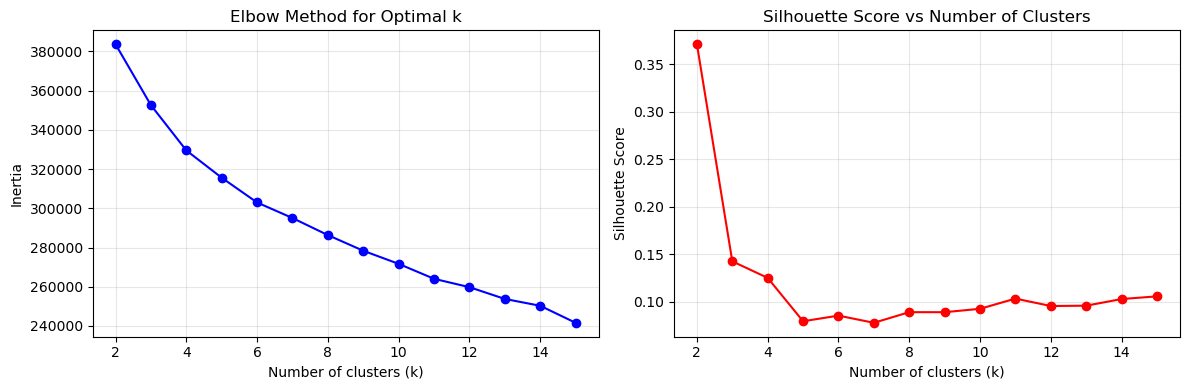

Suggested optimal k: 2


In [95]:
# Step 3: Determine optimal number of clusters
inertias = []
silhouette_scores = []
k_range = range(2, 16)

print("Testing different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Plot optimization metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Suggested optimal k: {optimal_k}")


In [98]:
optimal_k=4

In [99]:
# Step 4: Perform final clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(data_scaled)

print(f"Clustering completed with {optimal_k} clusters")
print(f"Cluster sizes: {np.bincount(cluster_labels)}")


Clustering completed with 4 clusters
Cluster sizes: [256  16 123  10]


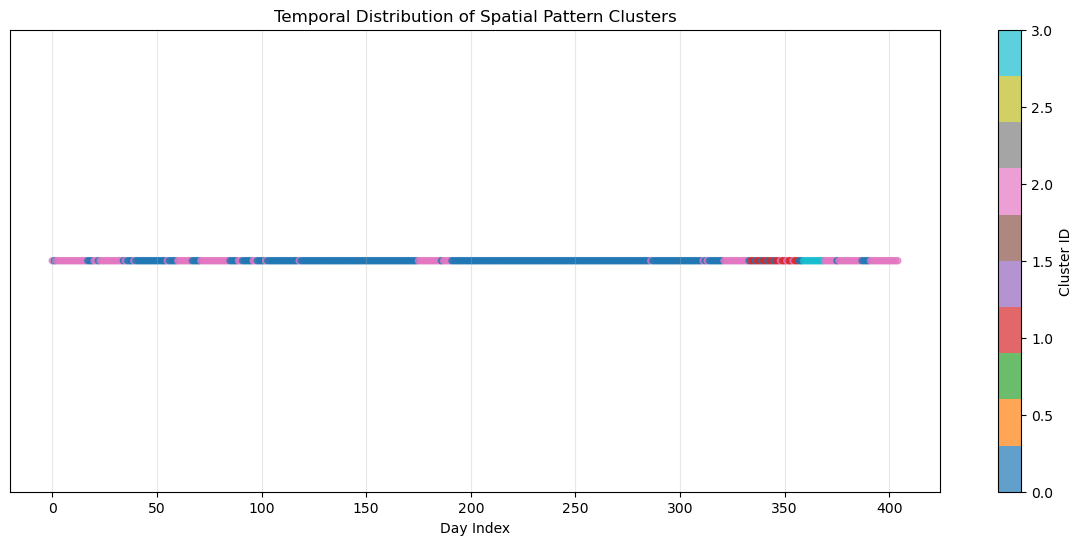

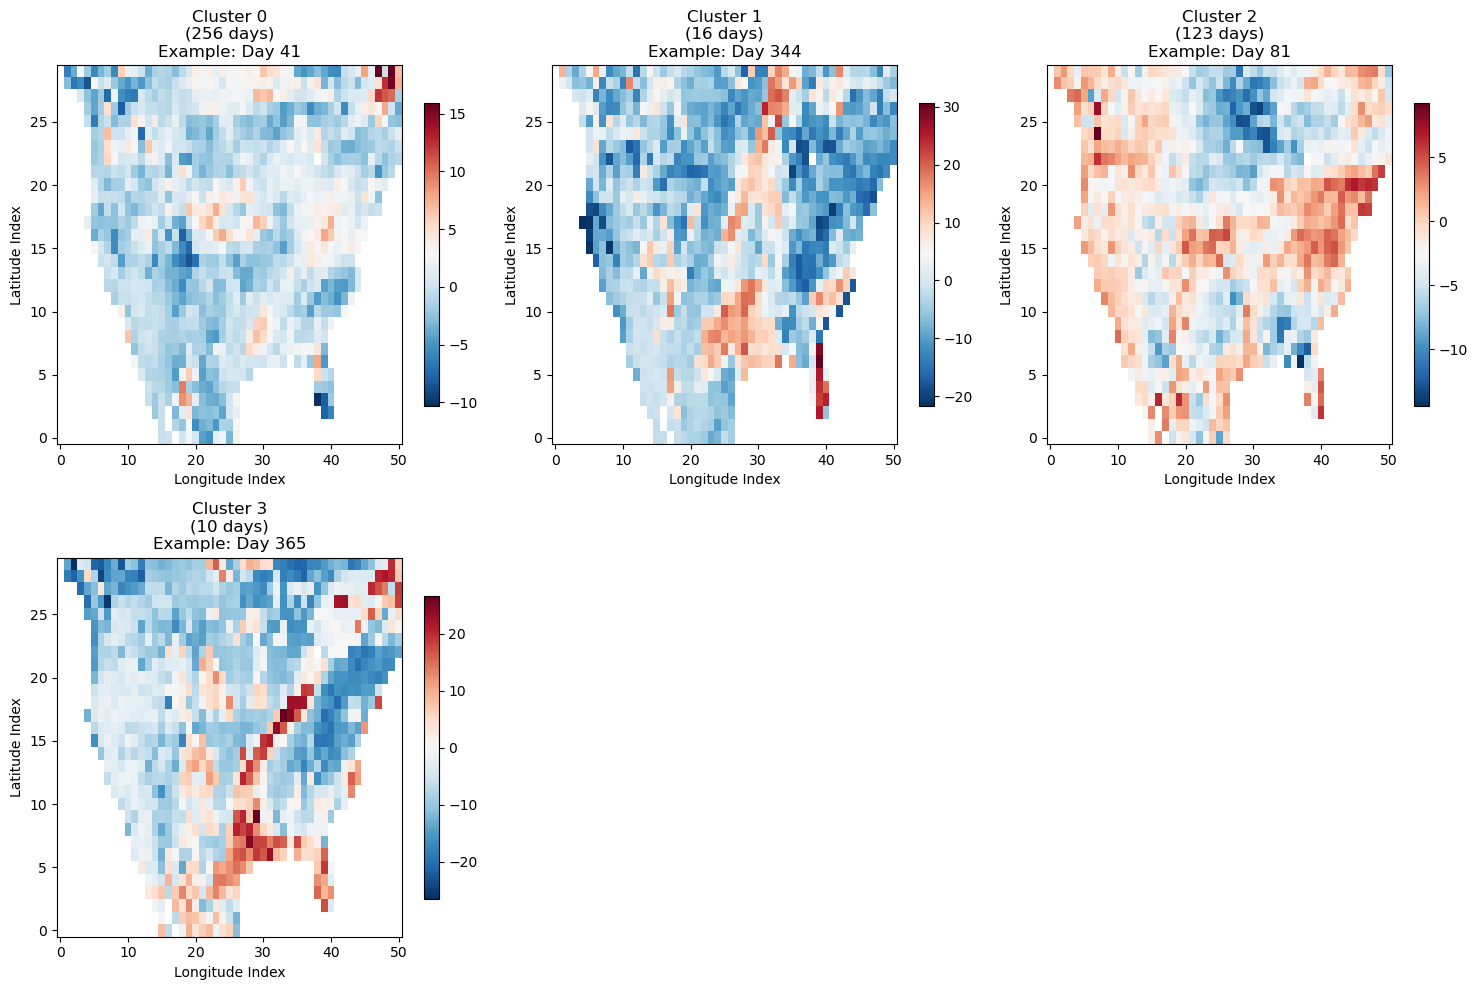

In [100]:
# Step 5: Analyze temporal distribution of clusters
plt.figure(figsize=(15, 6))
scatter = plt.scatter(valid_days, np.ones(len(valid_days)), 
                     c=cluster_labels, cmap='tab10', alpha=0.7, s=20)
plt.xlabel('Day Index')
plt.ylabel('')
plt.title('Temporal Distribution of Spatial Pattern Clusters')
plt.colorbar(scatter, label='Cluster ID')
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.show()

# Step 6: Show representative spatial patterns for each cluster
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for cluster_id in range(min(optimal_k, 6)):  # Show up to 6 clusters
    cluster_mask = cluster_labels == cluster_id
    cluster_days = valid_days[cluster_mask]
    
    if cluster_mask.sum() > 0:
        # Get the day closest to cluster centroid
        cluster_data = data_scaled[cluster_mask]
        centroid = kmeans_final.cluster_centers_[cluster_id]
        distances = np.linalg.norm(cluster_data - centroid, axis=1)
        representative_day_idx = cluster_days[np.argmin(distances)]
        
        # Reshape back to spatial grid for plotting
        # Need to reconstruct the full spatial pattern including NaN locations
        full_spatial_pattern = np.full((n_lat, n_lon), np.nan)
        
        # Map the land-only data back to the full grid
        land_pattern = data[representative_day_idx].reshape(n_lat, n_lon)[valid_locations_mask.reshape(n_lat, n_lon)]
        
        # This is a bit complex - let's use a simpler approach
        # Just use the original data for visualization
        spatial_pattern = data[representative_day_idx]
        
        im = axes[cluster_id].imshow(spatial_pattern, cmap='RdBu_r', aspect='auto', origin='lower')
        axes[cluster_id].set_title(f'Cluster {cluster_id}\n({cluster_mask.sum()} days)\nExample: Day {representative_day_idx}')
        axes[cluster_id].set_xlabel('Longitude Index')
        axes[cluster_id].set_ylabel('Latitude Index')
        plt.colorbar(im, ax=axes[cluster_id], shrink=0.8)

# Hide empty subplots
for i in range(optimal_k, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

## Extra code

In [17]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')


In [28]:
test_US = ensMean_anom.isel(init=100).SOILWATER_10CM.sel(lat=slice(24,52), lon=slice(230,293))

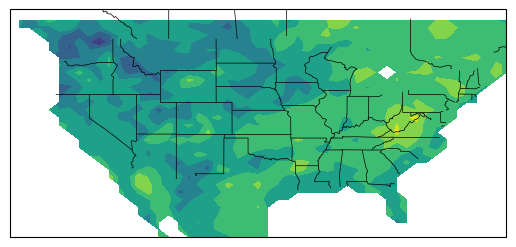

In [29]:
fig,axs= plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
axs.contourf(test_US.lon.values, test_US.lat.values, test_US.values, transform=ccrs.PlateCarree())
axs.add_feature(states_provinces,edgecolor='k',linewidth=0.5)